<a href="https://colab.research.google.com/github/anthonysalvatore/comp-machine-learning-a2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Assignment 2: Classify Images of Cancer**

## Introduction

Within this assignment, a modified version of the 'CRCHistoPhenotypes' dataset is used to perform two major tasks being:

*   Classify cell images according to whether a given cell image represents a cancerous cell or not. 
*   Classify cell images according to cell-type.

Machine learning will be used to develop the classification systems capable of performing the afforementioned tasks. Different techniques will be explored to ultimately arrive at a model capable of performing classification to a degree that is in line with the existing literature.

## Setting environment, loading data

In [98]:
#!git clone https://github.com/anthonysalvatore/comp-machine-learning-a2 # only run in colab
IMAGE_FILE_PATH = './Image_classification_data/patch_images/' # change if not in colab
DATA_FILE_PATH = './Image_classification_data/' 

In [ ]:
#!pip install -q -U keras-tuner # run if not installed in environment

In [193]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import keras.backend as K
import keras_tuner as kt
import random

In [100]:
# load the CSV files
main_data = pd.read_csv(DATA_FILE_PATH + 'data_labels_mainData.csv', index_col='InstanceID') 
extra_data = pd.read_csv(DATA_FILE_PATH + 'data_labels_extraData.csv', index_col='InstanceID')

## EDA

In [101]:
print(main_data.head())
print(extra_data.head())

            patientID  ImageName cellTypeName  cellType  isCancerous
InstanceID                                                          
22405               1  22405.png   fibroblast         0            0
22406               1  22406.png   fibroblast         0            0
22407               1  22407.png   fibroblast         0            0
22408               1  22408.png   fibroblast         0            0
22409               1  22409.png   fibroblast         0            0
            patientID  ImageName  isCancerous
InstanceID                                   
12681              61  12681.png            0
12682              61  12682.png            0
12683              61  12683.png            0
12684              61  12684.png            0
12685              61  12685.png            0


In [102]:
# display summary statistics of main_data
print(main_data.describe())
print(extra_data.describe())

         patientID     cellType  isCancerous
count  9896.000000  9896.000000  9896.000000
mean     29.762025     1.501516     0.412187
std      17.486553     0.954867     0.492253
min       1.000000     0.000000     0.000000
25%      14.000000     1.000000     0.000000
50%      26.000000     2.000000     0.000000
75%      47.000000     2.000000     1.000000
max      60.000000     3.000000     1.000000
         patientID   isCancerous
count  10384.00000  10384.000000
mean      80.38203      0.287943
std        9.40388      0.452826
min       61.00000      0.000000
25%       71.00000      0.000000
50%       81.00000      0.000000
75%       88.00000      1.000000
max       99.00000      1.000000


In [103]:
# confirm variable types and check for null values
print(main_data.info())
print(extra_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9896 entries, 22405 to 1629
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   patientID     9896 non-null   int64 
 1   ImageName     9896 non-null   object
 2   cellTypeName  9896 non-null   object
 3   cellType      9896 non-null   int64 
 4   isCancerous   9896 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 463.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10384 entries, 12681 to 20032
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   patientID    10384 non-null  int64 
 1   ImageName    10384 non-null  object
 2   isCancerous  10384 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 324.5+ KB
None


As shown from the information generated above, we can see that we will be working with mostly numerical data with some objects fields defining the labels of the cells and images. This has also shown that there are no 'null' values in the data, but we will perform additional checks for constant values and null values to confirm what is shown above.

In [104]:
# Checking for constant values
# Determine if any features of the dataframe have constant value across all observations
constant = []
for feature in main_data.columns:
    if main_data[feature].nunique() == 1:
        constant.append(feature)
        
if len(constant) > 0:
    print("The main_data dataframe contains constant features.")
    for item in constant:
        print(f"{item} is constant.")
else:
    print("The main_data dataframe does not contain any constant features.")

# Repeat the same process for the extra data
constants = []
for feature in extra_data.columns:
    if main_data[feature].nunique() == 1:
        constants.append(feature)
        
if len(constants) > 0:
    print("The extra_data dataframe contains constant features.")
    for items in constants:
        print(f"{items} is constant.")
else:
    print("The extra_data dataframe does not contain any constant features.")

The main_data dataframe does not contain any constant features.
The extra_data dataframe does not contain any constant features.


In [105]:
# Checking for missin/null values
# Confirming results of .info()
# Determine if the dataframe contains missing values
missing = False
for feature in main_data:
    for observation in feature:
        # We define missing values as None types, empty strings, or the NumPy type NaN
        if observation is None or observation == '' or observation == np.NaN:
            missing = True
if missing == True:
    print("The main_data dataframe contains missing values.")
else:
    print("The main_data dataframe does not contain any missing values.")

# Repeat the same process for the extra data
missings = False
for features in extra_data:
    for observations in features:
        # We define missing values as None types, empty strings, or the NumPy type NaN
        if observations is None or observations == '' or observations == np.NaN:
            missings = True
if missings == True:
    print("The extra_data dataframe contains missing values.")
else:
    print("The extra_data dataframe does not contain any missing values.")

The main_data dataframe does not contain any missing values.
The extra_data dataframe does not contain any missing values.


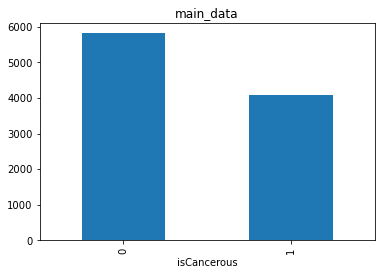

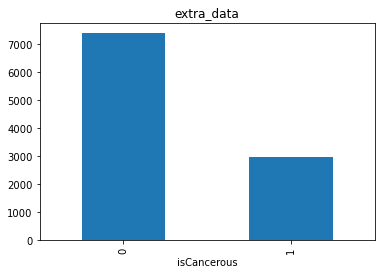

In [106]:
# visualize the distribution of isCancerous
main_data['isCancerous'].value_counts().plot(kind='bar')
plt.title('main_data')
plt.xlabel('isCancerous')
plt.show()

extra_data['isCancerous'].value_counts().plot(kind='bar')
plt.title('extra_data')
plt.xlabel('isCancerous')
plt.show()

# display a sample image
img = Image.open(IMAGE_FILE_PATH+'1.png')
img.show()

The bar charts clearly show that the Main data is relatively evenly distributed. However, the Extra data plot conveys that there is nearly double the non-cancerous (0) cells in the dataframe when compared to those that are labelled cancerous (1).

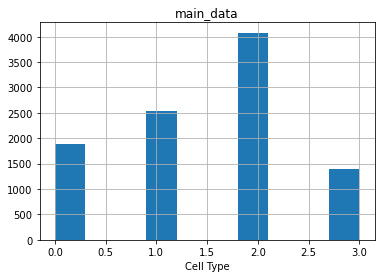

In [107]:
# visualize the distribution of cellType
main_data['cellType'].hist()
plt.title('main_data')
plt.xlabel('Cell Type')
plt.show()

The distribution above shows the modal for the main_data sample are of type 2 (epithelial). The keys are as follows:
<br>
0.   fibroblast
1.   inflammatory
2.   epithelial
3.   others 

We can now plot the cell type against the isCancerous field using a stacked bar chart, to determine if there is any relationship between the two fields that may help.

<AxesSubplot:xlabel='cellType'>

<Figure size 576x432 with 0 Axes>

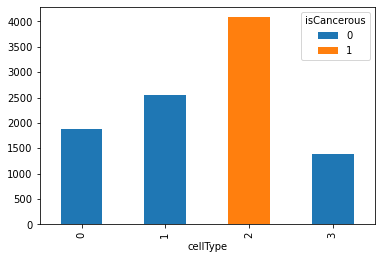

In [108]:
plt.figure(figsize=(8,6))
main_data.groupby(['cellType', 'isCancerous']).size().unstack().plot(kind='bar', stacked=True)

The chart clearly demonstrates that all cells of type 2 are cancerous, while every other cell type (0, 1 & 3) have no cancerous cells present. We can confirm the results through a cross table:

In [109]:
table = pd.crosstab(main_data['cellType'], main_data['isCancerous'])
print(table)

isCancerous     0     1
cellType               
0            1888     0
1            2543     0
2               0  4079
3            1386     0


The cross table echoes the findings of the bar chart, that all cancerous cells belong to the epitherial cell type (2). While epitherial cells are the most common type of cell in which cancers develop [1], they are obivoulsy not all cancerous cells in a real-life setting. Despite this, we will be proceeding with the assumption that every cell of type 2 is cancerous as this is how the data has been presented in this case study.

## Model Development

From our EDA, we have discovered that accuracy is adequate for the task of classifying a cell as cancerous or not. This is supported by the even distribtuion of classes and the fact that it is a binary class. However, since it is often more valuable to know if a cell is cancerous rather than not in a real-world setting, the recall could also be used, to minimize the number of false negatives.
<br>
For the task of cell type classification, since there are multiple classes to predict, accuracy may not be the best metric to use. Instead, the F1-score can be used, as it provides a good expression of precision and recall and is more robust than accuracy when multiple classes are involved. It is especially useful here since our cellType field will likely be much more unevenly distributed.
<br><br>
[pull relevant accuracy scores from literature, refer to here and set as target]
<br><br>
From the EDA, we discovered that every cell which was epitherial was cancerous. Knowing this, we can assign a label of '2' in the cellType column for each cancerous cell in the extra data dataframe.

In [110]:
extra_data.loc[extra_data['isCancerous'] == 1, 'cellType'] = 2
extra_data.loc[extra_data['isCancerous'] == 1, 'cellTypeName'] = 'epitherial'
extra_data

,patientID,ImageName,isCancerous,cellType,cellTypeName
InstanceID,,,,,
12681,61,12681.png,0,NaN,NaN
12682,61,12682.png,0,NaN,NaN
12683,61,12683.png,0,NaN,NaN
12684,61,12684.png,0,NaN,NaN
12685,61,12685.png,0,NaN,NaN
...,...,...,...,...,...
20028,99,20028.png,0,NaN,NaN
20029,99,20029.png,0,NaN,NaN
20030,99,20030.png,0,NaN,NaN


After applying the change to the extra data dataframe, we can merge it with the main data dataframe. Using both the main and extra data is well justified in the case of classifying isCancerous since both contain the full data needed. The extra data dataframe can supplement the main data in the case of cellType classification, as it now contains some data pertaining to cellType. However, since we were only able to discern epitherial cells from our EDA, the data is likely to be heavily skewed towards cellType 2 and may cause the classifier to have more of a bias for classifying cells as belonging to cell type 2. This will be explored further throughout the report. After merging the dataframes, a distribution of cell types can be seen in the graph below.

In [111]:
df = pd.concat([main_data, extra_data]).sort_index()
df

,patientID,ImageName,cellTypeName,cellType,isCancerous
InstanceID,,,,,
1,36,1.png,fibroblast,0.0,0
2,36,2.png,fibroblast,0.0,0
3,36,3.png,fibroblast,0.0,0
4,36,4.png,fibroblast,0.0,0
5,36,5.png,fibroblast,0.0,0
...,...,...,...,...,...
22438,27,22438.png,others,3.0,0
22439,27,22439.png,others,3.0,0
22442,27,22442.png,others,3.0,0


<AxesSubplot:>

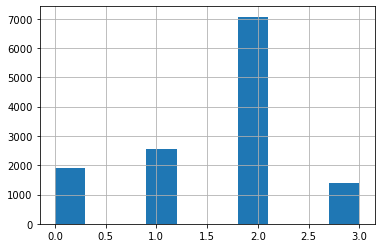

In [112]:
df['cellType'].hist()

As expected, imputing a value of 2 for each cellType in the extra data dataframe that contained a cancerous cell has further inbalanced the classes within this field.
<br><br>
We will now create two datasets off of the merged dataframe to perform each of the two classification tasks required. This is necessary since we have missing values in our cellType and cellTypeName column so we need to distinguish between the two before we perform a split. We also drop all unnecessary columns here for each dataframe. Only the labels and image name are needed for model training purposes.

In [113]:
df_cancerous = df.drop(['patientID', 'cellTypeName', 'cellType'], axis=1)
df_type = df.dropna().drop(['patientID', 'cellTypeName', 'isCancerous'], axis=1)

In [114]:
print(df_cancerous)
print(df_type)

            ImageName  isCancerous
InstanceID                        
1               1.png            0
2               2.png            0
3               3.png            0
4               4.png            0
5               5.png            0
...               ...          ...
22438       22438.png            0
22439       22439.png            0
22442       22442.png            0
22443       22443.png            0
22444       22444.png            0

[20280 rows x 2 columns]
            ImageName  cellType
InstanceID                     
1               1.png       0.0
2               2.png       0.0
3               3.png       0.0
4               4.png       0.0
5               5.png       0.0
...               ...       ...
22438       22438.png       3.0
22439       22439.png       3.0
22442       22442.png       3.0
22443       22443.png       3.0
22444       22444.png       3.0

[12886 rows x 2 columns]


We now have a clean dataframe for each classification task, containing no missing values.
<br><br>
Next, we split each dataframe into test, validation and training sets to be used for model training, validation and testing respectively. Here we choose a standard 60/20/20 split

In [115]:
# train/val/test split for both dataframes
train_data_c, test_data_c = train_test_split(df_cancerous, test_size=0.2, random_state=42)
train_data_c, val_data_c = train_test_split(train_data_c, test_size=0.25, random_state=42)

train_data_t, test_data_t = train_test_split(df_type, test_size=0.2, random_state=42)
train_data_t, val_data_t = train_test_split(train_data_t, test_size=0.25, random_state=42)

print("Cancerous train data : {}, Cancerous val data: {}, Cancerous test data: {}".format(train_data_c.shape[0], val_data_c.shape[0], test_data_c.shape[0]))
print("Cell type train data : {}, Cell type val data: {}, Cell type test data: {}".format(train_data_t.shape[0], val_data_t.shape[0], test_data_t.shape[0]))

Cancerous train data : 12168, Cancerous val data: 4056, Cancerous test data: 4056
Cell type train data : 7731, Cell type val data: 2577, Cell type test data: 2578


array([[<AxesSubplot:title={'center':'isCancerous'}>]], dtype=object)

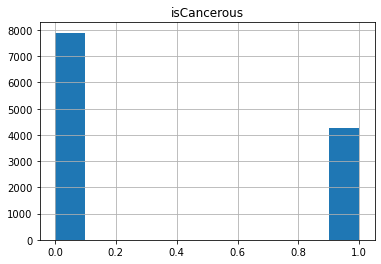

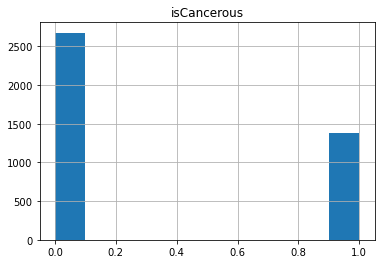

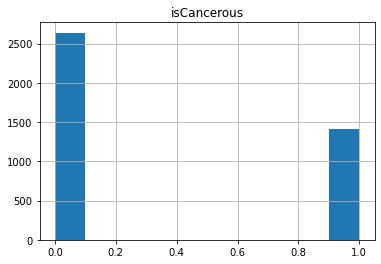

In [116]:
train_data_c.hist()
val_data_c.hist()
test_data_c.hist()

array([[<AxesSubplot:title={'center':'cellType'}>]], dtype=object)

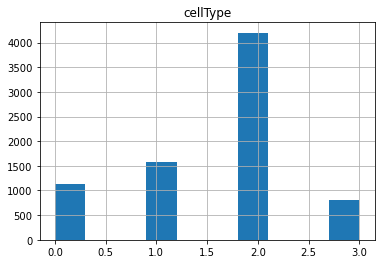

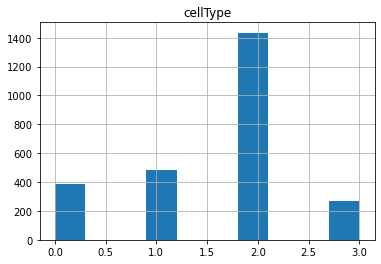

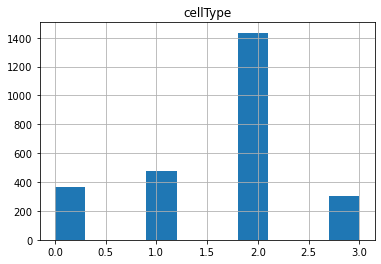

In [117]:
train_data_t.hist()
val_data_t.hist()
test_data_t.hist()

Distribution appears fairly similar between train/test/val for all pairings.
<br>
Since this is an image classification problem, a neural network works very well on the non-linear and huge number of parameters of an image. Since we intend to use neural networks for this project, a method of evaluating the rate of learning of the network is necessary so we can decide on next-step actions. We can plot the learning curve of the NN training process using the function below. This function will serve as our diagnostic tool.


In [118]:
# code taken from [2]
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Baseline Model

We require a baseline model as our initial solution. We will iterate over this model throughout remainder of the project, exploring different avenues that can lead to improvements. We will initially use an multi-layer perceptron (MLP) model and later promote this basic model to the more complex convolutional neural network (CNN).
<br><br>
We need to set some initial parameters for our NN, pertaining to the input dimension, hidden layer dimension and number of classes to output. We will define these parameters below for both of our two classification problems. The hidden layer hyper parameter can be tuned later but will be set at 256 for both initially. 256 represents the value each RGB chanel can range from, so is a fair initial estimate here.

In [119]:
INPUT_DIM_c = (27,27,3)
HIDDEN_LAYER_DIM_c = 256
OUTPUT_CLASSES_c = 2

INPUT_DIM_t = (27,27,3)
HIDDEN_LAYER_DIM_t = 256
OUTPUT_CLASSES_t = 4

With the above parameters defined, we can begin to build out the model. For this, we will use the popular machine learning library tensorflow, specifically the API keras which provides a Python interface for artificial neural networks. We work in layers, building our neural network up in a number of interconnected layers, defined by our set parameters.
<br> We use the sequential API as it is the simplest.

In [120]:
model_c = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM_c),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_c),
    tf.keras.layers.Dense(OUTPUT_CLASSES_c)
])

model_t = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM_t),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_t),
    tf.keras.layers.Dense(OUTPUT_CLASSES_t)
])

The first layer transforms the images from a two dimensional image array, to a one dimensional array (27 * 27 * 3 = 2187 px). The next two layers are densely connected neural layers, with the last being related to the class to be classified for each problem.
<br><br>
model.summary() can print a brief summary of the model that we have created.

In [121]:
model_c.summary()
model_t.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 2187)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               560128    
                                                                 
 dense_13 (Dense)            (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 2187)              0         
                                                                 
 dense_14 (Dense)         

tf.keras.utils.plot_model can present the model as a figuire

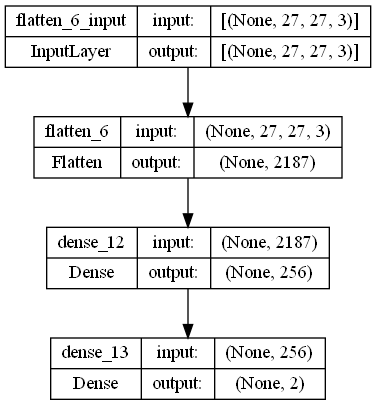

In [122]:
tf.keras.utils.plot_model(model_c, show_shapes=True)

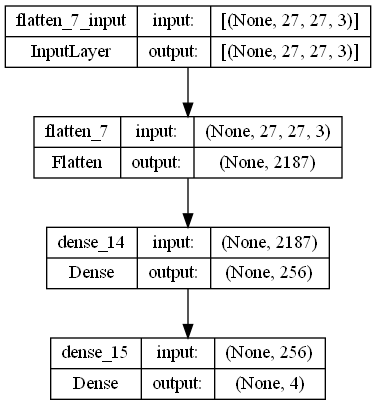

In [123]:
tf.keras.utils.plot_model(model_t, show_shapes=True)

The model requires a few other parameters before it is ready for training. These are included during the compile step as seen below. We set the loss function, optimizer and metrics. As detailed before, we will use accuracy for the cancerous classification task, and F1 score for the cell type classification task.

In [124]:
# define F1 score metric 
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# code from [3]

In [125]:
# compile models
model_c.compile(optimizer='SGD',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])

model_t.compile(optimizer='SGD',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[get_f1])

When training the model, it is important to load the data to memory in batches, since our data will be large and complex. We achieve this in keras via image data generators. 

In [126]:
# convert class labels to string - required for proceeding function
train_data_c['isCancerous'] = train_data_c['isCancerous'].astype('str')
val_data_c['isCancerous'] = val_data_c['isCancerous'].astype('str')
test_data_c['isCancerous'] = test_data_c['isCancerous'].astype('str')

train_data_t['cellType'] = train_data_t['cellType'].astype('str')
val_data_t['cellType'] = val_data_t['cellType'].astype('str')
test_data_t['cellType'] = test_data_t['cellType'].astype('str')

In [127]:
# isCancerous classification task
train_datagen_c = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_c = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen_c = ImageDataGenerator(rescale=1./255, data_format='channels_last')


batch_size = 32

train_generator_c = train_datagen_c.flow_from_dataframe(
        dataframe=train_data_c,
        directory=IMAGE_FILE_PATH, # change if not in colab
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_c = val_datagen_c.flow_from_dataframe(
        dataframe=val_data_c,
        directory=IMAGE_FILE_PATH, # change if not in colab
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator_c = test_datagen_c.flow_from_dataframe(
        dataframe=test_data_c,
        directory=IMAGE_FILE_PATH, # change if not in colab
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [128]:
# cellType classification task
train_datagen_t = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_t = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen_t = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator_t = train_datagen_t.flow_from_dataframe(
        dataframe=train_data_t,
        directory=IMAGE_FILE_PATH, # change if not in colab
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_t = val_datagen_t.flow_from_dataframe(
        dataframe=val_data_t,
        directory=IMAGE_FILE_PATH, # change if not in colab
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator_t = test_datagen_t.flow_from_dataframe(
        dataframe=test_data_t,
        directory=IMAGE_FILE_PATH, # change if not in colab
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7731 validated image filenames belonging to 4 classes.
Found 2577 validated image filenames belonging to 4 classes.
Found 2578 validated image filenames belonging to 4 classes.


In the above, we've defined an image data generator which will load each of our images into memory in batches, based off the provided directory and file name given in our dataframe. We also normalize each of the pixels from their regular scale of 0-255.
<br><br>
With all of that out of the way, we are now able fit our models to the data, and observe the results.

In [129]:
history_c = model_c.fit_generator(train_generator_c, validation_data = validation_generator_c, epochs=50, verbose=0)
history_t = model_t.fit_generator(train_generator_t, validation_data = validation_generator_t, epochs=50, verbose=0)

C:\Users\Anthony\AppData\Local\Temp\ipykernel_24092\1273040687.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_c = model_c.fit_generator(train_generator_c, validation_data = validation_generator_c, epochs=50, verbose=0)
C:\Users\Anthony\AppData\Local\Temp\ipykernel_24092\1273040687.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_t = model_t.fit_generator(train_generator_t, validation_data = validation_generator_t, epochs=50, verbose=0)


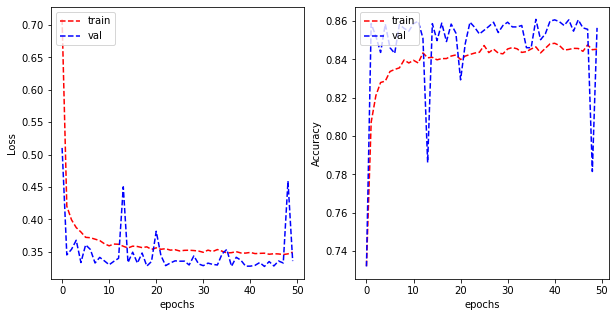

In [130]:
plot_learning_curve(history_c.history['loss'], history_c.history['val_loss'], 
                    history_c.history['categorical_accuracy'], history_c.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

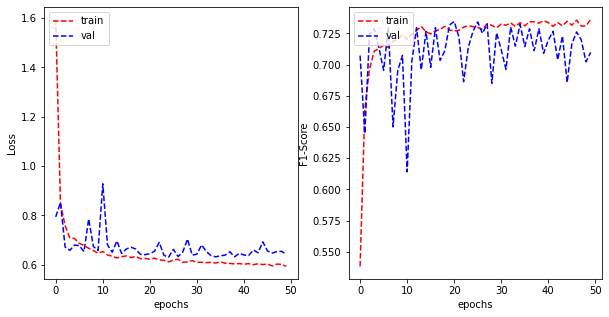

In [136]:
plot_learning_curve(history_t.history['loss'], history_t.history['val_loss'], 
                    history_t.history['get_f1'], history_t.history['val_get_f1'], 
                    metric_name='F1-Score')

In [134]:
test_loss_c, test_acc_c = model_c.evaluate(test_generator_c, verbose=0)
print('Test loss:', test_loss_c)
print('Test accuracy:', test_acc_c)

Test loss: 0.36015111207962036
Test accuracy: 0.8407297730445862


In [135]:
test_loss_t, test_f1_t = model_t.evaluate(test_generator_t, verbose=0)
print('Test loss:', test_loss_t)
print('Test f1 score:', test_f1_t)

Test loss: 0.6488176584243774
Test f1 score: 0.7099686861038208


The learning curves above demonstrates a decent predictive rate for both our classification tasks. The models generalise well to the unseen test data, performing as good as the validation set. They do not appear to be overfitting, as the training curve and validation curve appear quite close.
<br>The task of classifying a cell as cancerous or not is an especially strong predictor. This is to be expected, given what we know about the dataset and the classification task for each. Predicting isCancerous is a binary problem, with a complete dataset. Predicting the cellType invovles prediction of four labels, with an incomplete dataset. The learner involved in predicting the isCancerous class should always perform better than that of the cellType predictor. <br>However, there are many iterative improvements we can make to both predictors to further bolster their preditive power and have them fall in line closer with the expected result from the literature. One such is testing different base models, to determine which is more appropriate for this task. 
<br>We will now implement a CNN base model, compare the results to our MLP base model and make an educated judgement about which model to further make imporvements on. Much of the steps taken before for the MLP model are the same, since CNN and MLP methods share much of the same foundation.

We need to select A base model for the CNN task. An IaNet model should be sufficient here, as they are a simple model that can operate on small images. Instead of adding layers as in the MLP model, we add blocks, which contain a convolution, activation and pooling layer. The pooling layer causes a downscaling of the image.

In [137]:
reg_lambda = 0.0001
# isCancerous CNN model
model_leNet_c = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES_c, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

# cellType CNN model
model_leNet_t = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES_t, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [147]:
model_leNet_c.compile(optimizer='SGD',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])

model_leNet_t.compile(optimizer='SGD',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[get_f1])

In [148]:
history_c = model_leNet_c.fit_generator(train_generator_c, validation_data = validation_generator_c, epochs=50, verbose=0)
history_t = model_leNet_t.fit_generator(train_generator_t, validation_data = validation_generator_t, epochs=50, verbose=0)

C:\Users\Anthony\AppData\Local\Temp\ipykernel_24092\3036129016.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_c = model_leNet_c.fit_generator(train_generator_c, validation_data = validation_generator_c, epochs=50, verbose=0)
C:\Users\Anthony\AppData\Local\Temp\ipykernel_24092\3036129016.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_t = model_leNet_t.fit_generator(train_generator_t, validation_data = validation_generator_t, epochs=50, verbose=0)


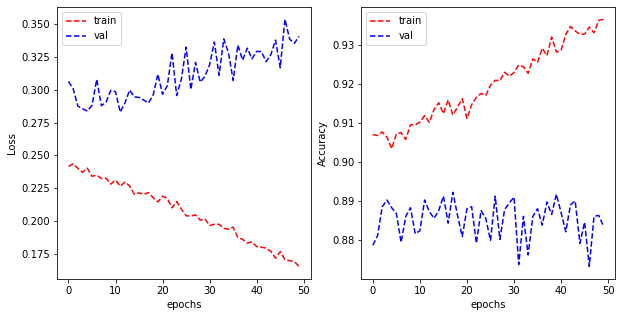

In [149]:
plot_learning_curve(history_c.history['loss'], history_c.history['val_loss'], 
                    history_c.history['categorical_accuracy'], history_c.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

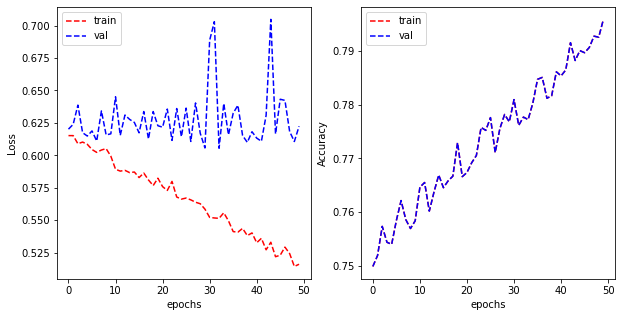

In [150]:
plot_learning_curve(history_t.history['loss'], history_t.history['val_loss'], 
                    history_t.history['get_f1'], history_t.history['val_get_f1'], 
                    metric_name='F1-Score')

In [151]:
test_loss_c, test_acc_c = model_leNet_c.evaluate(test_generator_c, verbose=0)
print('Test loss:', test_loss_c)
print('Test accuracy:', test_acc_c)

Test loss: 0.3581399917602539
Test accuracy: 0.8774654865264893


In [152]:
test_loss_t, test_f1_t = model_leNet_t.evaluate(test_generator_t, verbose=0)
print('Test loss:', test_loss_t)
print('Test f1 score:', test_f1_t)

Test loss: 0.6400298476219177
Test f1 score: 0.7594702243804932


From the results above, we can see that the task of classifying a cell as cancerous sees a test accuraccy increase of about 5%, and a decrease in test loss of about 0.7. The task of classifying cellType also reveives an increase of about 5% in terms of performance, with loss remaining largely unchanged. It is clear that using a CNN is likely more suited to this task than using an MLP. The models both don't appear to be overfitting either, as the learning gap between the training set and validation set is quite small. The models also generalize well to unseen data as the test sets have performances close to that of the validaiton set.
<br><br>
For the remainder of this assignment we will be proceeding with a CNN model and making iterative imporovements to explore different options that may result in increased performance.

## Iterative Improvements

### Data Augmentation

Although the model does not appear to be overfitting, it may still be worthwile to perform some data augmentation and try improve our model performance.<br>
In data augmentation, we randomly perterbate the original dataset to form a larger dataset and use that for training. This only needs to be applied to the training set.

In [153]:
train_datagen_c = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)

train_generator_c = train_datagen_c.flow_from_dataframe(
        dataframe=train_data_c,
        directory=IMAGE_FILE_PATH, # change if not in colab
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

train_datagen_t = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)

train_generator_t = train_datagen_t.flow_from_dataframe(
        dataframe=train_data_t,
        directory=IMAGE_FILE_PATH, # change if not in colab
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 7731 validated image filenames belonging to 4 classes.


In [154]:
history_c = model_leNet_c.fit_generator(train_generator_c, validation_data = validation_generator_c, epochs=50, verbose=0)
history_t = model_leNet_t.fit_generator(train_generator_t, validation_data = validation_generator_t, epochs=50, verbose=0)

C:\Users\Anthony\AppData\Local\Temp\ipykernel_24092\3036129016.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_c = model_leNet_c.fit_generator(train_generator_c, validation_data = validation_generator_c, epochs=50, verbose=0)
C:\Users\Anthony\AppData\Local\Temp\ipykernel_24092\3036129016.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_t = model_leNet_t.fit_generator(train_generator_t, validation_data = validation_generator_t, epochs=50, verbose=0)


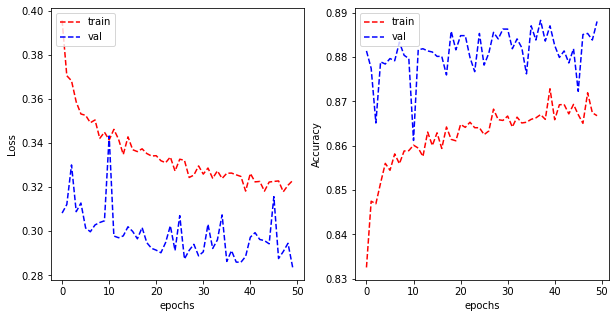

In [155]:
plot_learning_curve(history_c.history['loss'], history_c.history['val_loss'], 
                    history_c.history['categorical_accuracy'], history_c.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

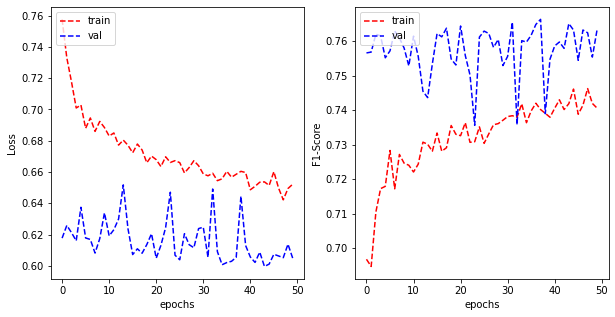

In [160]:
plot_learning_curve(history_t.history['loss'], history_t.history['val_loss'], 
                    history_t.history['get_f1'], history_t.history['val_get_f1'], 
                    metric_name='F1-Score')

In [157]:
test_loss_c, test_acc_c = model_leNet_c.evaluate(test_generator_c, verbose=0)
print('Test loss:', test_loss_c)
print('Test accuracy:', test_acc_c)

Test loss: 0.28937700390815735
Test accuracy: 0.8902859687805176


In [158]:
test_loss_t, test_f1_t = model_leNet_t.evaluate(test_generator_t, verbose=0)
print('Test loss:', test_loss_t)
print('Test f1 score:', test_f1_t)

Test loss: 0.6122269630432129
Test f1 score: 0.7566659450531006


Through data augmentation here, we can see improvements across the board on both our models. Our isCancerous model has lower loss and higher levels of accuracy than the base CNN model. The cellType classififer also sees better loss values, but no significant f1-score improvements.

## Hyperparameter Tuning

After augmenting the dataset, we can now set about performing some hyperparameter tuning. Here, we will be performing a random search over the hyperparameter space to try find some values that result in an optimal model. The parameters we will be searching over are the learning rate, number of filters, and kernel size.

In [198]:
# define model builders
def build_model_c(learning_rate, num_filters, kernel_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(27, 27, 3)),
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
        
        tf.keras.layers.Conv2D(num_filters, kernel_size, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(num_filters, kernel_size, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Conv2D(64, (3, 3)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES_c, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
    ])
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])
    
    return model

def build_model_t(learning_rate, num_filters, kernel_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(27, 27, 3)),
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
        
        tf.keras.layers.Conv2D(num_filters, kernel_size, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(num_filters, kernel_size, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Conv2D(64, (3, 3)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES_t, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
    ])
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[get_f1])
    
    return model

In [195]:
# define the hyperparameters for random search over isCancerous classification task
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'num_filters': [32, 64, 128],
    'kernel_size': [(3, 3), (5, 5)]
}

# perform random search
results_c = []
num_iterations = 10

for i in range(num_iterations):
    # sample hyperparameters from the grid
    learning_rate = random.choice(param_grid['learning_rate'])
    num_filters = random.choice(param_grid['num_filters'])
    kernel_size = random.choice(param_grid['kernel_size'])
    
    # build the model
    model = build_model_c(learning_rate, num_filters, kernel_size)
    
    # train the model using the generator
    history = model.fit_generator(
        train_generator_c,
        steps_per_epoch=len(train_generator_c),
        epochs=10,
        verbose=0
    )
    
    # evaluate the model on the validation data
    val_loss, val_accuracy = model.evaluate(validation_generator_c, verbose=0)
    
    # store the results
    results_c.append({
        'learning_rate': learning_rate,
        'num_filters': num_filters,
        'kernel_size': kernel_size,
        'val_loss': val_loss,
        'val_categorical_accuracy': val_accuracy
    })

C:\Users\Anthony\AppData\Local\Temp\ipykernel_24092\582202978.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


In [200]:
# define the hyperparameters for random search over isCancerous classification task
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'num_filters': [32, 64, 128],
    'kernel_size': [(3, 3), (5, 5)]
}

# perform random search
results_t = []
num_iterations = 10

for i in range(num_iterations):
    # sample hyperparameters from the grid
    learning_rate = random.choice(param_grid['learning_rate'])
    num_filters = random.choice(param_grid['num_filters'])
    kernel_size = random.choice(param_grid['kernel_size'])
    
    # build the model
    model = build_model_t(learning_rate, num_filters, kernel_size)
    
    # train the model using the generator
    history = model.fit_generator(
        train_generator_t,
        steps_per_epoch=len(train_generator_t),
        epochs=10,
        verbose=0
    )
    
    # evaluate the model on the validation data
    val_loss, val_f1 = model.evaluate(validation_generator_t, verbose=0)
    
    # store the results
    results_t.append({
        'learning_rate': learning_rate,
        'num_filters': num_filters,
        'kernel_size': kernel_size,
        'val_loss': val_loss,
        'val_get_f1': val_f1
    })

C:\Users\Anthony\AppData\Local\Temp\ipykernel_24092\894882575.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


In [206]:
# view results
print(max(results_c, key=lambda x: 'val_categorical_accuracy'))
print(max(results_t, key=lambda x:'val_get_f1'))


{'learning_rate': 0.01, 'num_filters': 64, 'kernel_size': (3, 3), 'val_loss': 0.3656878173351288, 'val_categorical_accuracy': 0.8611932992935181}
{'learning_rate': 0.001, 'num_filters': 64, 'kernel_size': (3, 3), 'val_loss': 1.1839885711669922, 'val_get_f1': 0.22941772639751434}


We can see from above that our random search did not yield any significant results, scoring worse performance-wise in terms of both of our two tasks.<br>
Given the length of time it takes to train the two models, we will not continue with an extended search of the hyperparamter space. A more extensive search could yield better performance results however

## References

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3927155/#:~:text=Epithelial%20tissue%20is%20also%20the,percent%20of%20all%20human%20cancers.<br>
[2] [link course notes] <br>
[3] https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d